# Comparing Total Hydrostatic Masses Between Analyses

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS and Lovisari samples both have hydrostatic mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper), and the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 50
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$ - XGA centering on

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [5]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [7]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|████████████████████▏                                   | 18/50 [03:05<05:50, 10.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|█████████████████████████▊                              | 23/50 [03:59<05:37, 12.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|██████████████████████████████▏                         | 27/50 [04:23<03:14,  8.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1682 does 

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell2219 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  89%|██████████████████████████████████████████████████▊      | 41/46 [05:55<01:06, 13.28s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source Abell2261
  warnings.warn("There are {0} alternative matches for observat

### Planck Selected with XMM follow-up - XGA centering on

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [6]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [7]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['xmm_ra'].values
dec = lovisari['xmm_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=True, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 60/120 [13:17<10:18, 10.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 61/120 [13:36<12:40, 12.88s/it]/mnt/pact/dt237/

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050101/0603050101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

Setting up Galaxy Clusters:  19%|██████████████████████████████████▎                                                                                                                                                | 23/120 [05:26<25:04, 15.51s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0401920101 and is very close to the user supplied coordinates of G062.42-46.41. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G062.42-46.41 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  22%|█

Setting up Galaxy Clusters:  39%|██████████████████████████████████████████████████████████████████████                                                                                                             | 47/120 [09:10<07:46,  6.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G159.85-73.47 fit G159.85-73.47_ra22.986_dec-13.577_ri0.08216656642693615_ro0.0882082257230344_grpTrue_mincnt5_ident68916107_9_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G159.85-73.47 fit G159.85-73.47_ra22.986_dec-13.577_ri0.012083318592196492_ro0.024166637184392985_grpTrue_mincnt5_ident68916107_0_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no

Setting up Galaxy Clusters:  40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 48/120 [09:24<10:37,  8.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.19574984170276016_ro0.20179150348370956_grpTrue_mincnt5_ident20760763_32_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.08579159728948131_ro0.0918332590704307_grpTrue_mincnt5_ident20760763_14_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} 

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.024166658269619407_ro0.030208322837024255_grpTrue_mincnt5_ident40542796_4_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.06041664567404851_ro0.06645831024145336_grpTrue_mincnt5_ident40542796_10_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.19574993198391719_ro0.20783326111872688_grpTrue_mincnt5_ident40542796_29_constant*tbabs*apec.f

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.12808328882898284_ro0.1341249533963877_grpTrue_mincnt5_ident40542796_21_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.03315075373638254_ro0.22100502490921697_grpTrue_mincnt5_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.10391658263232947_ro0.10995824441327887_grpTrue_mincnt5_ident20760763_17_constant*tbabs*

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.0_ro0.22100502490921697_grpTrue_mincnt5_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.726_dec13.56_ri0.10391663055936344_ro0.10995829512676829_grpTrue_mincnt5_ident40542796_17_constant*tbabs*apec.fits could not be loaded in as there are no matching spectra available
  warnings.warn("{src} fit {f} could not be loaded in as there are no matching spectra "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:940: UserWarning: G164.18-38.89 fit G164.18-38.89_ra44.740717630253435_dec13.587693396258224_ri0.07249994137139265_ro0.0797499355085319_grpTrue_mincnt5_ident20760763_12_consta

Setting up Galaxy Clusters:  41%|█████████████████████████████████████████████████████████████████████████                                                                                                          | 49/120 [09:30<09:17,  7.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G166.13+43.39 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  42%|████████████████████████████████████████████████████████████████████████████                                                                                                       | 51/120 [09:43<08:12,  7.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G171.94-40.65 was not successful, or no matching spectrum has been loaded

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280101/0551280101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning

Setting up Galaxy Clusters:  52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 63/120 [11:56<13:06, 13.79s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G228.49+53.12 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 65/120 [12:06<08:44,  9.54s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G229.94+15.29 has not been detected in all region files, so generating and fitting products with the 'region' reg

Setting up Galaxy Clusters:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 84/120 [14:55<06:24, 10.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G266.03-21.25 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 88/120 [15:35<05:05,  9.54s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:164: UserWarning: After applying the criteria for the minimum amount of cluster required on an observation, G272.10-40.15 cannot b

## Running PSF Correction

In [10]:
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [8]:
lov_lit_ms = [lovisari[lovisari['name'] == n].iloc[0][['m500', 'm500-', 'm500+']].values*1e+14
               for n in lovisari_srcs.names]
lov_lit_ms = Quantity(lov_lit_ms, 'Msun')

loc_lit_ms = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_ms = Quantity(loc_lit_ms, 'Msun')

NameError: name 'locuss_srcs' is not defined

### Conversion Temperatures

In [9]:
loc_conv_txs = []
lov_conv_txs = []

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])
    
lov_conv_txs = Quantity(lov_conv_txs, 'keV')
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

NameError: name 'locuss_srcs' is not defined

## Hydrostatic Mass Comparison to Literature - Density from $S_B$ Profiles

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.05$R_{500}$

In [11]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [12]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [13]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 15.] keV>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [-10.,  10.]>, 'type': 'uniform'}]

In [26]:
loc_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|█████████████████████████████████████████████████████████████████| 46/46 [09:05<00:00, 11.85s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for RXCJ1212.3-1816 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
Generating products of type(s) spectrum: 100%|████████████████████████████████████████| 210/210 [1:37:02<00:00, 27.72s/it]
Generating products of type(s) annular spectrum set components: 100%|███████████████| 2591/2591 [3:02:19<00:00,  4.22s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████████████████| 540/540 [19:57<00:00,  2.22s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fi

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1229.14529149 1100.49414714 1434.2044592  1077.20861762 1205.54654386
 1195.1302909 ]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▉                   | 2/41 [00:51<17:02, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [774.42196213 665.44705779 746.11352968 681.37584153 685.10009775
 828.1675351 ]


Fitting data, inverse Abel transforming, and measuring densities:   7%|█▍                  | 3/41 [01:17<16:22, 25.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1699.98765624  646.40236017 1918.27820976 1387.04695041 1572.68120703
 1809.8705095 ]


Fitting data, inverse Abel transforming, and measuring densities:  10%|█▉                  | 4/41 [01:41<15:34, 25.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1500.92908433 1472.6148793  1865.17866583 1634.31679224 1638.29708579
 1834.95739728]


Fitting data, inverse Abel transforming, and measuring densities:  12%|██▍                 | 5/41 [02:05<14:50, 24.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [400.29722854 848.42829828 226.49995004 220.07103945 501.52264934
 535.918696  ]


Fitting data, inverse Abel transforming, and measuring densities:  15%|██▉                 | 6/41 [02:30<14:24, 24.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1086.78668289  933.62483145 1393.53970219  988.70529035 1498.06920996
 1428.21232594]


Fitting data, inverse Abel transforming, and measuring densities:  20%|███▉                | 8/41 [03:22<13:55, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 275.67461288  240.13298236 1816.91650966 1698.29479213 1807.75307692
 1805.81781215]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██████             | 13/41 [05:35<12:14, 26.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [878.11184366 163.799635   855.31244206 684.88924786 832.42565843
 851.13661748]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██████▍            | 14/41 [06:02<11:52, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1065.78406437 1057.58119807  970.29089328  835.70485822  915.86931289
 1062.79013263]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██████▉            | 15/41 [06:27<11:16, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [159.0592     448.76189408 248.16303007 203.0743091  294.47503272
 357.13292933]


Fitting data, inverse Abel transforming, and measuring densities:  51%|█████████▋         | 21/41 [09:04<08:30, 25.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [183.85273046 569.07435164 304.87873843 804.91964279 784.84250988
 616.01056552]


Fitting data, inverse Abel transforming, and measuring densities:  56%|██████████▋        | 23/41 [09:58<07:50, 26.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [145.54357295 410.57231546 100.79500788 138.95675495 176.88377555
 251.31035006]


Fitting data, inverse Abel transforming, and measuring densities:  59%|███████████        | 24/41 [10:23<07:20, 25.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2004.56599566 1313.47958286 2335.84275693 1999.36416183 2195.14693363
 2336.56860684]


Fitting data, inverse Abel transforming, and measuring densities:  71%|█████████████▍     | 29/41 [12:40<05:18, 26.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 625.33450923 1370.61242589 1852.37515868 2199.49654914 2257.30949464
 2066.78582232]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████████████▉     | 30/41 [13:04<04:45, 25.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1082.58546147  704.00347939 1376.5534789  1308.18992686 1374.11344113
 1451.78868018]


Fitting data, inverse Abel transforming, and measuring densities:  83%|███████████████▊   | 34/41 [14:56<03:11, 27.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [718.1483636  741.23957528 798.07725339 650.80938357 772.70054067
 808.41530569]


Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████████████▌ | 38/41 [16:46<01:21, 27.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1334.64431143  693.51305064 1257.99124804 1009.1704986  1137.15980445
 1260.75062611]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████████████████ | 39/41 [17:13<00:53, 26.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [407.38021617 417.38695752 450.25177498 313.64427925 408.24227703
 512.2851286 ]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████████████████| 41/41 [18:03<00:00, 26.42s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 979.15733576  244.53660969 1976.01397204 1753.05637497 1414.9678549
 1915.96872798]


Generating Abell2697 hydrostatic mass profile:   0%|                                               | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [567.1133016  822.23760149 562.22116335 464.28934121 911.91309171
 406.83524979]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 112.62816036  164.03784508 1300.17448828  110.86765916  110.27143709
  565.53697013]


Generating Abell0068 hydrostatic mass profile:   2%|▊                                      | 1/46 [00:49<37:25, 49.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [301.88963025 477.75982239 386.94530657 438.98725263 314.31978327
 322.37969616]


Generating Abell2813 hydrostatic mass profile:   4%|█▋                                     | 2/46 [01:39<36:35, 49.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [628.1654569  809.68872461 641.87711542 777.9772017  904.5102499
 464.18701743]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [198.33568831 339.2362879  582.0418806  157.49398188 130.83359708
 516.36129738]


Generating Abell0115S hydrostatic mass profile:   7%|██▍                                   | 3/46 [02:29<35:37, 49.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1269.07210821 1720.52584687 2440.86683826 1509.24977213  583.62211925
 1503.77843876]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 216.61464814  218.3541352  1493.88546074  261.84745373  230.81344076
  283.71737725]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell141 hydrostatic mass profile:   9%|███▍                                    | 4/46 [03:18<34:32, 49.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [770.5768317  640.67409535 637.90986532 700.12870846 527.73651003
 596.81632278]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [418.33260742 417.24907459 427.91133001 599.56501932 370.87311282
 520.87887552]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|███▌                             | 5/46 [04:06<33:27, 48.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1281.4723147  1446.52166738 1393.8731075  1473.94681327 2154.43383618
 1620.66060174]


Generating Abell0209 hydrostatic mass profile:  13%|█████                                  | 6/46 [04:51<31:46, 47.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 123.27812719  121.77752594 1085.53340786  197.99987777  172.18183634
  132.50103824]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [615.68999254 887.05925208 668.77851025 516.38991462 497.61777579
 510.15878694]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 810.3126211  1006.11956817 1192.71545334  490.18950031  826.20743311
 1047.10185018]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0267 hydrostatic mass profile:  15%|█████▉                                 | 7/46 [05:43<31:54, 49.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [333.45575025 868.87699614 495.02054145 535.34718636 392.83124713
 350.12300367]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 104.97944888  103.51498585 1058.73297278  107.20836752  118.98996847
  100.34559668]


Generating Abell0291 hydrostatic mass profile:  17%|██████▊                                | 8/46 [06:32<31:04, 49.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [579.74401899 666.48220885 249.66064897 505.74993782 360.15814483
 338.90027826]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.86562287  92.77132765 744.68959442  86.29210982  86.44225057
  89.87285067]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0383 hydrostatic mass profile:  20%|███████▋                               | 9/46 [07:24<30:47, 49.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1458.59207319 1640.95112913 1356.78816024 1228.57497744 2016.46332043
 1392.1202297 ]


Generating Abell0521 hydrostatic mass profile:  22%|████████▎                             | 10/46 [08:14<30:04, 50.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1105.33182931 1080.51437031  757.67929506 1194.19720228  635.04159047
  490.31416787]


Generating Abell0586 hydrostatic mass profile:  24%|█████████                             | 11/46 [09:04<29:09, 49.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [504.18243852 708.28179266 483.64210262 573.74564421 487.30422511
 367.53719489]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0611 hydrostatic mass profile:  26%|█████████▉                            | 12/46 [09:54<28:22, 50.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 367.20904717 1184.93339418  388.78242005  338.97173692  347.97180286
  362.06834492]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.60458918 408.91457512 726.79793402 262.48369654 182.83739475
 459.44343009]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  30%|█████████▋                      | 14/46 [10:43<26:27, 49.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 412.72060485 1441.56189812  760.10310555  726.22904953  401.74894506
  396.99977257]


Generating Abell0750 hydrostatic mass profile:  33%|████████████▍                         | 15/46 [11:30<19:22, 37.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.69472376 114.84551217 695.19350072 117.97012132 121.07318106
 131.62658457]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 983.67558276 1224.2819758  1201.77185115 1175.41165145  785.29672287
  987.38229512]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0781 hydrostatic mass profile:  37%|██████████████                        | 17/46 [12:19<19:27, 40.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [970.927525   868.61705408 298.49909469 715.02991959 295.28052691
 388.15400206]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1061.40731167  855.89230064  889.90343609  566.7368844   441.57927329
  503.33502912]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.72419312 148.78557002 888.87485087 104.69937598 116.53076619
 178.35511401]


Generating Abell0901 hydrostatic mass profile:  39%|██████████████▊                       | 18/46 [13:06<15:37, 33.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1246.16942689 1342.27257972  801.59988675  788.08846624 1917.07821065
 1155.57346944]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.16924606  86.74695989 707.99746917 102.28462049 105.10011796
  84.84045493]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell0907 hydrostatic mass profile:  41%|███████████████▋                      | 19/46 [13:57<16:50, 37.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [505.38247116 550.15290495 251.56941362 403.70347144 282.79677232
 265.69936334]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  46%|██████████████▌                 | 21/46 [14:51<17:15, 41.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1325.51631177 1536.79171315 1477.07472372 1549.29736285 1127.72422333
  808.58219796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.52047365  88.1376582  886.46036704  79.35946793 145.05574682
  60.00437741]


Generating RXCJ1212.3-1816 hydrostatic mass profile:  50%|████████████████                | 23/46 [15:40<13:13, 34.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [660.49129924 873.57374486 677.99363357 717.49594489 701.18405534
 744.82002707]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  52%|████████████████▋               | 24/46 [16:24<10:56, 29.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 947.34091755  693.42436913  676.30653685 1015.3318928   403.09311843
  744.11688657]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 747.38400436  797.76705426  660.01174282 1007.65011631  921.7193512
  517.01994332]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 327.44709736  783.18475777 1171.68756968  247.17638004  185.22412647
  911.09542473]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1689 hydrostatic mass profile:  54%|████████████████████▋                 | 25/46 [17:14<11:53, 33.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 910.32549114 1048.76846368 1223.43819075 1323.65251025  769.68935715
  999.36476059]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.09435953  81.68835781 580.18339307  90.08733145  89.59344442
  78.29428329]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1758N hydrostatic mass profile:  57%|████████████████████▉                | 26/46 [18:09<12:57, 38.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1012.8473945  1020.9216412  1063.39693695 1089.74823672  664.69162616
  956.67063261]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1868.98194458 2035.14397942 1958.30849841 1971.31222757 1069.02958135
 2034.55827176]


Generating Abell1763 hydrostatic mass profile:  59%|██████████████████████▎               | 27/46 [18:59<13:11, 41.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [317.13256638 659.65696242 504.44096458 414.41158961 318.8996841
 397.2666281 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [186.52248614 175.94511086 718.463923   341.70381355 395.08742751
 203.191875  ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell1835 hydrostatic mass profile:  61%|███████████████████████▏              | 28/46 [19:50<13:13, 44.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1584.83867    1278.02598612 1523.25163121 1677.25750785  684.7397223
 1238.53455913]


Generating Abell1914 hydrostatic mass profile:  63%|███████████████████████▉              | 29/46 [20:44<13:17, 46.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.83955571 542.20018831 520.49005345 560.24129114 489.92006779
 389.74517263]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 93.75143991  95.62412169 438.49170815  88.3046599   84.51631137
  96.82641406]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1454.8+2233 hydrostatic mass profile:  65%|████████████████████▊           | 30/46 [21:38<13:01, 48.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1006.61269726 1190.4734581   464.8373566   784.57655389  362.28289502
  351.73757168]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████████████▌            | 31/46 [22:27<12:13, 48.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  99.21679447   93.21008315 1212.91865996  104.73780153  116.82433156
   90.71059295]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.19128471 627.03392545 509.6213491  337.12652852 218.29885306
 233.79496648]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [142.64775801 303.73948085 606.05477417 111.11460508 146.10578614
 394.55865546]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating ZwCl1459.4+4240 hydrostatic mass profile:  70%|██████████████████████▎         | 32/46 [23:23<11:52, 50.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [740.19458382 896.02432952 569.57267585 788.78886665 577.87900025
 539.42568209]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  72%|██████████████████████▉         | 33/46 [24:12<10:55, 50.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [392.47279162 547.31288255 316.35484994 327.55590171 473.78777153
 382.44606372]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [518.52109798 563.76905632 295.10153529 416.6435194  224.27940709
 228.15489261]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  79.76652336   79.85067413 1211.88922726   84.96892575   98.49498485
   60.84709344]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2111 hydrostatic mass profile:  74%|████████████████████████████          | 34/46 [25:07<10:21, 51.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.87136748 449.5230545  416.16337586 364.72247482 335.17935023
 318.37057533]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [111.27708263 124.81874274 433.88006505 105.80514683  93.78599599
 134.33478376]


Generating Abell2204 hydrostatic mass profile:  76%|████████████████████████████▉         | 35/46 [25:58<09:27, 51.56s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [372.96364414 450.53096189 169.28089899 386.57201583 163.09390769
 160.35278459]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|██████████████████████████▌      | 37/46 [26:58<08:05, 53.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [576.96940617 646.76821766 201.20669915 561.28210047 249.5460558
 296.70771259]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.94850713  81.27909556 674.91153433  79.6878515   76.25331038
  65.94835005]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating Abell2261 hydrostatic mass profile:  83%|███████████████████████████████▍      | 38/46 [27:54<05:35, 41.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator h

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [694.59103417 994.75949087 720.33175607 662.93095763 589.46425068
 627.91542199]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.79518459  88.1207048  548.33066065  79.46700639  84.38160565
  90.23217604]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  85%|███████████████████████████▏    | 39/46 [28:45<05:10, 44.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1283.57600998 1557.72591091 1689.15894139 1351.96258824 2335.90857698
 1677.73696983]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.12539256  81.64165903 678.52453769  86.42911592  87.96925991
  83.08453341]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|████████████████████████████▋    | 40/46 [29:36<04:36, 46.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [614.43265943 991.29383973 980.51126552 692.99860457 467.69771938
 501.35846518]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.36319491  80.89359703 433.89616571  79.01066175  83.79408514
  87.6692705 ]


Generating Abell2390 hydrostatic mass profile:  89%|█████████████████████████████████▊    | 41/46 [30:27<03:57, 47.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.99651791  87.90874527 792.17286459  79.6377599   81.27776413
  87.48022075]


Generating Abell2537 hydrostatic mass profile:  91%|██████████████████████████████████▋   | 42/46 [31:23<03:18, 49.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [429.55400704 571.64791155 420.54666679 431.68262927 448.98504708
 358.35620876]


Generating Abell2552 hydrostatic mass profile:  93%|███████████████████████████████████▌  | 43/46 [32:11<02:27, 49.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 246.00974857  703.66361839 1613.07400609  176.15362549  130.38861514
 1069.14900191]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [487.88368142 839.56614177 410.92754599 547.18217114 771.28835684
 466.51002653]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [133.72127814 213.09248203 469.59284984 109.19569227 138.8340162
 250.37321635]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████████████████▎ | 44/46 [33:01<01:39, 49.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [309.08403475 544.97267215 430.83689959 465.93205172 399.78986831
 385.17455942]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 951.60763441 1641.61677995 1021.73666611  882.53485986 1226.19794497
 1516.60353953]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████████████████▏| 45/46 [33:52<00:49, 49.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [538.7204532  680.54843825 501.85528042 662.56080272 443.78359452
 503.80976796]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [106.73791571 114.48968649 609.88127849 107.36471136 115.74461835
 152.95543262]


Complete: 100%|███████████████████████████████████████████████████████████████████████████| 46/46 [34:40<00:00, 45.24s/it]


In [14]:
lov_sb_dblbeta_simpvikh_105_mp = inv_abel_dens_onion_temp(lovisari_srcs, lovisari_srcs.r500*1.05, 'double_beta', 
                                                          'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                          temp_min_snr=30)

Running XSPEC Fits: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.43s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G042.82+56.61 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for G171.94-40.65 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51:

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Running XSPEC Simulations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:15<00:00,  1.17s/it]
Fitting data, inverse Abel transforming, and measuring densities:   1%|█▍                                                                                                                                             | 1/97 [00:28<45:16, 28.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [336.08689617 519.28713653 812.29621339 184.43411786 195.35661088
 186.58901874]


Fitting data, inverse Abel transforming, and measuring densities:   2%|██▉                                                                                                                                            | 2/97 [00:55<44:14, 27.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1993.87243363  334.54772645 2488.56804583 2424.57361282 2365.04510709
 2472.21491753]


Fitting data, inverse Abel transforming, and measuring densities:   3%|████▍                                                                                                                                          | 3/97 [01:24<43:49, 27.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [825.09864027 799.88910106 780.73293918 759.55351668 786.160237
 841.02837932]


Fitting data, inverse Abel transforming, and measuring densities:   5%|███████▎                                                                                                                                       | 5/97 [02:19<42:11, 27.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [649.58385749 869.56789818 716.42749536 931.12017505 906.1173903
 830.90117035]


Fitting data, inverse Abel transforming, and measuring densities:   8%|███████████▊                                                                                                                                   | 8/97 [03:40<40:24, 27.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [320.58935036 254.72245258 298.98490884 300.0975722  350.99178487
 444.11941891]


Fitting data, inverse Abel transforming, and measuring densities:   9%|█████████████▎                                                                                                                                 | 9/97 [04:04<38:21, 26.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [141.763737   405.7735763  151.37634595 119.82228701 121.41011993
 172.50176348]


Fitting data, inverse Abel transforming, and measuring densities:  10%|██████████████▋                                                                                                                               | 10/97 [04:32<38:49, 26.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [625.32354922 233.2060358  506.61253889 342.69712863 400.60521421
 605.86976625]


Fitting data, inverse Abel transforming, and measuring densities:  14%|████████████████████▍                                                                                                                         | 14/97 [06:35<40:26, 29.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 906.71097123  943.41307589 1083.19966389  963.23073683 1050.33863005
 1076.48356802]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [237.83233776 501.44304462 930.92787177 194.03610297 189.63418499
 163.74518576]


Fitting data, inverse Abel transforming, and measuring densities:  16%|███████████████████████▍                                                                                                                      | 16/97 [07:29<37:40, 27.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [153.4461346  485.17818026 126.53297454 278.10262056 313.9990918
 330.56265495]


Fitting data, inverse Abel transforming, and measuring densities:  18%|████████████████████████▉                                                                                                                     | 17/97 [07:55<36:29, 27.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 499.45433833  854.07168691 1170.84703245  287.54943568  356.90310792
  333.71216512]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█████████████████████████████▎                                                                                                                | 20/97 [09:25<37:08, 28.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [328.38993145 301.79290765 294.85838273 384.50045464 377.8630501
 441.17284503]


Fitting data, inverse Abel transforming, and measuring densities:  26%|████████████████████████████████████▌                                                                                                         | 25/97 [11:48<34:31, 28.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [612.67887738 674.47849348 787.05521928 604.29053754 683.84404662
 855.77946275]


Fitting data, inverse Abel transforming, and measuring densities:  27%|██████████████████████████████████████                                                                                                        | 26/97 [12:13<32:45, 27.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [850.79014483 310.19052514 850.56577568 856.73793863 994.06038567
 860.56510368]


Fitting data, inverse Abel transforming, and measuring densities:  28%|███████████████████████████████████████▌                                                                                                      | 27/97 [12:39<31:39, 27.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [426.2219832  409.11212833 313.22290453 526.2734402  527.54901816
 569.33893752]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██████████████████████████████████████████▍                                                                                                   | 29/97 [13:32<30:16, 26.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1596.31031742 1069.53890702 2095.28295726 1804.81452769 1984.89641868
 2088.17063683]


Fitting data, inverse Abel transforming, and measuring densities:  32%|█████████████████████████████████████████████▍                                                                                                | 31/97 [14:24<29:21, 26.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [196.39811574 506.59329872 870.32362382 270.38990702 240.13339406
 210.67591564]


Fitting data, inverse Abel transforming, and measuring densities:  34%|████████████████████████████████████████████████▎                                                                                             | 33/97 [15:17<28:15, 26.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1716.88166404  696.59901761 1999.62893884 1698.26720361 1816.08005154
 1999.07421151]


Fitting data, inverse Abel transforming, and measuring densities:  35%|█████████████████████████████████████████████████▊                                                                                            | 34/97 [15:41<26:56, 25.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [269.81950185 826.76872823 458.97528479 535.89334456 614.74959455
 659.79005679]


Fitting data, inverse Abel transforming, and measuring densities:  37%|████████████████████████████████████████████████████▋                                                                                         | 36/97 [16:34<26:20, 25.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [453.36236496 490.62998507 877.5944299  770.06132916 841.10056127
 894.95714363]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██████████████████████████████████████████████████████▏                                                                                       | 37/97 [16:57<24:51, 24.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [234.4961624  450.99708389 642.48227629 165.85071598 146.49025564
 164.72834646]


Fitting data, inverse Abel transforming, and measuring densities:  41%|██████████████████████████████████████████████████████████▌                                                                                   | 40/97 [18:13<24:00, 25.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 372.01646862  384.36465141 1912.709954   1736.58003821 1832.75172222
 1870.54552169]


Fitting data, inverse Abel transforming, and measuring densities:  42%|████████████████████████████████████████████████████████████                                                                                  | 41/97 [18:37<23:25, 25.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [466.19953362 476.55668305 345.42977306 852.04572866 801.57846751
 397.53917253]


Fitting data, inverse Abel transforming, and measuring densities:  43%|█████████████████████████████████████████████████████████████▍                                                                                | 42/97 [19:02<22:59, 25.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [234.76204463 512.71326075 721.74397312 470.62850465 558.25842778
 848.37094899]


Fitting data, inverse Abel transforming, and measuring densities:  44%|██████████████████████████████████████████████████████████████▉                                                                               | 43/97 [19:28<22:39, 25.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [389.60744088 744.66700474 423.2248548  378.32196532 460.95568741
 430.67758295]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 528.52039886 1112.57814943 1833.95187452 1298.6314339  1435.19911939
 1525.56483416]


Fitting data, inverse Abel transforming, and measuring densities:  47%|███████████████████████████████████████████████████████████████████▎                                                                          | 46/97 [20:44<21:27, 25.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 791.68664339  945.79025126 1386.5190859   918.48350499 1049.07497853
  673.25202058]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [201.37384645 354.46739017 903.77193491 217.327569   209.52153042
 218.93749909]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███████████████████████████████████████████████████████████████████████▋                                                                      | 49/97 [22:06<20:59, 26.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 547.11227598  716.31192228 2052.07648239 1687.35036544 1687.77397752
 1874.37302025]


Fitting data, inverse Abel transforming, and measuring densities:  53%|██████████████████████████████████████████████████████████████████████████▋                                                                   | 51/97 [23:02<20:41, 27.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1175.94819222  359.34219927 1361.41514649 1046.27397715 1211.29811875
 1418.31739702]


Fitting data, inverse Abel transforming, and measuring densities:  55%|█████████████████████████████████████████████████████████████████████████████▌                                                                | 53/97 [23:55<19:28, 26.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1163.37629171  442.76695349 1616.93294048 1518.0253544  1527.96591723
 1526.57492833]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 54/97 [24:25<19:44, 27.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1152.68102611 1310.56862546 1981.25763993 1867.91972061 1759.85195872
 1484.46086157]


Fitting data, inverse Abel transforming, and measuring densities:  58%|█████████████████████████████████████████████████████████████████████████████████▉                                                            | 56/97 [25:19<18:38, 27.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 692.32652583  385.57796998 1703.10789668 1304.34784419 1093.95101547
 1570.08783247]


Fitting data, inverse Abel transforming, and measuring densities:  59%|███████████████████████████████████████████████████████████████████████████████████▍                                                          | 57/97 [25:44<17:45, 26.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 926.94717308 1459.15892504 1500.66105405 1705.65632685 1623.38143602
 1286.14323017]


Fitting data, inverse Abel transforming, and measuring densities:  61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                       | 59/97 [26:33<16:08, 25.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 548.13478803  359.44188098 1680.37185449 1583.61663263 1622.83752466
 1418.12899249]


Fitting data, inverse Abel transforming, and measuring densities:  64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 62/97 [28:02<16:00, 27.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 445.68864349  859.32698114 1563.66260979 1732.21113287 1779.36543748
 1285.6050569 ]


Fitting data, inverse Abel transforming, and measuring densities:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 64/97 [28:54<14:34, 26.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [228.12089525 338.16459831 768.19682402 198.18223994 193.68633582
 198.94095058]


Fitting data, inverse Abel transforming, and measuring densities:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 65/97 [29:17<13:37, 25.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [176.9805931  472.46850975 581.48260231 432.8479032  551.72870766
 600.33202098]


Fitting data, inverse Abel transforming, and measuring densities:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 71/97 [31:59<11:07, 25.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [274.55134898 561.57220231 433.71789432 677.02520682 706.77547409
 678.43453582]


Fitting data, inverse Abel transforming, and measuring densities:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 74/97 [33:15<09:44, 25.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 599.71666691 1222.58894767 1313.82405368 1037.32060377 1225.64374656
 1527.53052578]


Fitting data, inverse Abel transforming, and measuring densities:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 76/97 [34:09<09:08, 26.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [935.23974416 419.73888626 856.45048509 542.66779661 643.9182541
 919.88555922]


Fitting data, inverse Abel transforming, and measuring densities:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 77/97 [34:33<08:27, 25.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [462.3859579  355.26203513 321.94836988 677.56101229 573.57201657
 539.9941868 ]


Fitting data, inverse Abel transforming, and measuring densities:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 78/97 [34:59<08:04, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [466.64965519 607.43976938 525.08354937 537.5175199  604.79031191
 781.33977737]


Fitting data, inverse Abel transforming, and measuring densities:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 79/97 [35:22<07:29, 24.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 751.89272596 1149.90334657  589.37319559  647.47563527  653.63589023
  709.10171715]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [698.15069431 536.77569661 646.53015845 502.57551281 546.38752135
 627.21786844]


Fitting data, inverse Abel transforming, and measuring densities:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 81/97 [36:20<07:05, 26.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [511.07921805 518.38634336 296.93931381 478.49113957 528.82933889
 688.68136487]


Fitting data, inverse Abel transforming, and measuring densities:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 82/97 [36:44<06:29, 25.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [838.10508915 661.28181503 786.03862972 585.34332336 654.14664318
 825.30425124]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [551.48892928 995.9523332  759.97559924 866.47700471 903.90352252
 994.96051423]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G304.67-31.66's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 89/97 [40:08<03:58, 29.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.38873587 387.73334629 150.18747529 195.52697618 257.1720813
 312.98937583]


Fitting data, inverse Abel transforming, and measuring densities:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 91/97 [41:11<03:03, 30.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 899.07948219 1582.33783196 1437.00206685 1631.16397373 1688.34767993
 1719.69661399]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 92/97 [41:37<02:25, 29.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [546.33026285 468.39780237 626.89917693 541.76869292 635.15849152
 539.98567081]


Fitting data, inverse Abel transforming, and measuring densities:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 96/97 [43:21<00:26, 26.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 965.62825666 1047.19002798 1379.39322625 1594.47139837 1529.70927535
 1368.10131111]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [43:47<00:00, 27.09s/it]
Generating G002.74-56.18 hydrostatic mass profile:   1%|█▎                                                                                                                                                         | 1/119 [00:00<00:00, 1874.13it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with tho

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1443.33755785 1348.13208392  987.71807951 1249.83837227  856.21017201
  758.93318732]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:209: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating G006.70-35.54 hydrostatic mass profile:   3%|███▉                                                                                                                                                         | 3/119 [01:01<41:40, 21.56s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a suc

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [117.09412326 120.2280415  430.78337748 118.99895582 112.46559212
 164.54204   ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G008.44-56.35 hydrostatic mass profile:   4%|██████▌                                                                                                                                                      | 5/119 [01:37<50:47, 26.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.23248821  98.63385802 413.76769575  86.46866757  81.96388742
  98.84317125]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G008.93-81.23 hydrostatic mass profile:   5%|███████▉                                                                                                                                                     | 6/119 [02:09<39:59, 21.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G021.09+33.25 hydrostatic mass profile:   6%|█████████▏                                                                

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1140.44195773 1999.40861356  868.35747629  962.58848822 1808.91389106
 1673.96931626]


Generating G046.08+27.18 hydrostatic mass profile:   9%|██████████████▍                                                                                                                                             | 11/119 [04:20<54:14, 30.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1625.09738026 2118.96626885 1835.13857023 2034.56937024 1017.12121834
 2063.2212604 ]


Generating G049.20+30.86 hydrostatic mass profile:  11%|█████████████████                                                                                                                                           | 13/119 [04:48<40:23, 22.86s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.52283823  86.75260446 702.89850745  78.23410979  80.84024028
  68.93024913]


Generating G049.33+44.38 hydrostatic mass profile:  12%|██████████████████▎                                                                                                                                         | 14/119 [05:21<35:36, 20.35s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.5858973  113.42351297 752.69076183 104.9721002  117.0388945
 121.39383342]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G049.66-49.50 hydrostatic mass profile:  13%|███████████████████▋                                                                                                                                        | 15/119 [05:55<40:26, 23.33s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [184.9279969  239.52353077 638.28582082 142.52405665 173.25318308
 267.11772629]


Generating G053.52+59.54 hydrostatic mass profile:  13%|████████████████████▉                                                                                                                                       | 16/119 [06:32<45:37, 26.58s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 795.1065763  1165.76507672  746.59153371 1131.37795073  673.37707457
 1150.49699293]


Generating G055.60+31.86 hydrostatic mass profile:  14%|██████████████████████▎                                                                                                                                     | 17/119 [07:13<51:12, 30.13s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G056.81+36.31 hydrostatic mass profile:  16%|████████████████████████▉                                                                                                                                   | 19/119 [07:44<50:36, 30.36s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the m

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [979.5882675  881.75190888 856.43026494 927.22553224 378.24986815
 685.45577991]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:209: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating G056.96-55.07 hydrostatic mass profile:  17%|██████████████████████████▏                                                                                                                                 | 20/119 [08:16<39:52, 24.17s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a suc

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1189.78961301 1120.53384709  341.8425208  1104.32635845 1168.16008612
  765.64395304]


Generating G057.26-45.35 hydrostatic mass profile:  18%|███████████████████████████▌                                                                                                                                | 21/119 [08:46<41:36, 25.47s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G058.28+18.59 hydrostatic mass profile:  18%|████████████████████████████▊                                                                                                                               | 22/119 [09:13<41:54, 25.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the m

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 549.19878157  969.06955985 1045.99970697 1161.46533529  208.06171932
  267.5996229 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1280.18311689 1254.60061605  694.45467439 1073.42969427 1127.74132424
  776.6889611 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G062.42-46.41 hydrostatic mass profile:  19%|██████████████████████████████▏                                                                                                                             | 23/119 [10:13<55:59, 34.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G067.23+67.46 hydrostatic mass profile:  20%|███████████████████████████████▍                                          

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.81471092  90.70722675 488.46204996  80.97904749  86.27388252
  93.68106792]


Generating G071.61+29.79 hydrostatic mass profile:  21%|████████████████████████████████▊                                                                                                                           | 25/119 [11:20<53:41, 34.27s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [740.62471483 902.22994541 835.3902533  671.76977266 908.44151704
 898.08360171]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G072.80-18.72 hydrostatic mass profile:  23%|███████████████████████████████████▍                                                                                                                        | 27/119 [11:52<51:21, 33.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.39002588  93.35278459 659.33078242  79.80333398  90.4719426
  97.01882804]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G073.96-27.82 hydrostatic mass profile:  24%|████████████████████████████████████▋                                                                                                                       | 28/119 [12:26<39:26, 26.00s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.23585726  90.60025339 686.27825708  79.42198313  73.11393218
  89.31378733]


Generating G080.38-33.20 hydrostatic mass profile:  24%|██████████████████████████████████████                                                                                                                      | 29/119 [12:58<41:14, 27.50s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.77135062  94.78216752 490.53205542  84.39191257  84.88990392
 114.7709684 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G080.99-50.90 hydrostatic mass profile:  25%|███████████████████████████████████████▎                                                                                                                    | 30/119 [13:33<43:57, 29.63s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G083.28-31.03 hydrostatic mass profile:  26%|████████████████████████████████████████▋                                 

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [216.96968359 292.99378283 451.98334661 163.29628929 139.45578326
 339.93674966]


Generating G085.99+26.71 hydrostatic mass profile:  27%|█████████████████████████████████████████▉                                                                                                                  | 32/119 [14:30<42:00, 28.97s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1701.74459506 2168.02369474 1426.54452387 1748.28054892 1120.84163037
 2167.78766767]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G086.45+15.29 hydrostatic mass profile:  28%|███████████████████████████████████████████▎                                                                                                                | 33/119 [15:01<42:12, 29.44s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.15904069  96.98917709 558.94911711  86.14820108  89.42329858
 101.56115546]


Generating G092.73+73.46 hydrostatic mass profile:  29%|████████████████████████████████████████████▌                                                                                                               | 34/119 [15:31<42:07, 29.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [229.49276623 209.59539806 989.15140993 379.76534481 419.57049854
 189.25524467]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G096.87+24.21 hydrostatic mass profile:  30%|███████████████████████████████████████████████▏                                                                                                            | 36/119 [16:02<41:33, 30.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [277.39766661 524.16560239 479.3182526  330.94212464 328.76495697
 328.8651834 ]


Generating G097.73+38.11 hydrostatic mass profile:  31%|████████████████████████████████████████████████▌                                                                                                           | 37/119 [16:49<37:04, 27.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1027.53092076 1546.28127927 1164.3455673  1442.17991474 1395.34033609
 1365.23548294]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1635.7013553  1622.74776278 1375.72571026 1520.58989404 1637.98375947
 1535.68718435]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G098.95+24.86 hydrostatic mass profile:  32%|█████████████████████████████████████████████████▊                                                                                                          | 38/119 [17:24<39:11, 29.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 927.633927   1574.8981903  1605.75695927 1394.10843533  547.6773773
  814.76102804]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1266.19565522 1163.3232005   758.79164217 1344.05695083  464.48889996
  819.16276134]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G106.73-83.22 hydrostatic mass profile:  33%|███████████████████████████████████████████████████▏                                                                                                        | 39/119 [18:16<46:35, 34.94s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [147.68037858 300.69815352 876.88547676 122.70195649 114.24175802
 663.78931043]


Generating G113.82+44.35 hydrostatic mass profile:  34%|█████████████████████████████████████████████████████▋                                                                                                      | 41/119 [18:45<43:15, 33.28s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 558.89519018 1255.48100495 1919.56225959  382.46778993  296.88257181
 1442.30483139]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G124.21-36.48 hydrostatic mass profile:  35%|███████████████████████████████████████████████████████                                                                                                     | 42/119 [19:14<32:06, 25.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 103.59163778   97.30706929 1152.12830817   95.52535742  125.23738301
   94.81275122]


Generating G125.70+53.85 hydrostatic mass profile:  36%|████████████████████████████████████████████████████████▎                                                                                                   | 43/119 [20:06<39:47, 31.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G139.19+56.35 hydrostatic mass profile:  37%|█████████████████████████████████████████████████████████▋                                                                                                  | 44/119 [20:33<38:05, 30.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.09433143 102.35617908 658.62516255 102.09422196 115.8635318
 107.33644149]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G157.43+30.33 hydrostatic mass profile:  39%|████████████████████████████████████████████████████████████▎                                                                                               | 46/119 [20:59<35:41, 29.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [547.24155156 784.9807303  589.12662611 940.15708216 459.26503042
 683.61116192]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G159.85-73.47 hydrostatic mass profile:  39%|█████████████████████████████████████████████████████████████▌                                                                                              | 47/119 [21:28<27:22, 22.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1133.50270222 2051.78586167 1456.37231304 1221.05243669 1437.7742051
 1665.94617638]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 536.66816617  805.50234474 1568.00528538 1530.39349364  542.76844106
  525.73872528]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1345.02422538 1467.38881356 1488.31873768 1074.71751233 1340.9658411
 1507.72740808]


Generating G166.13+43.39 hydrostatic mass profile:  41%|████████████████████████████████████████████████████████████████▏                                                                                           | 49/119 [22:21<35:02, 30.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [349.29464963 633.08893221 395.97636195 414.40845425 408.19898495
 362.97073571]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.85599999  98.27824967 709.95041915  98.12912088 134.04779544
  98.00916204]


Generating G180.24+21.04 hydrostatic mass profile:  44%|████████████████████████████████████████████████████████████████████▏                                                                                       | 52/119 [23:11<31:06, 27.86s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.86910904  93.04959996 749.13925709  93.67889444  42.01346473
  94.017365  ]


Generating G186.39+37.25 hydrostatic mass profile:  46%|████████████████████████████████████████████████████████████████████████                                                                                    | 55/119 [23:37<20:19, 19.05s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 110.43075464  125.33448698 1158.62484189  105.6124418   123.14617557
  177.39995091]


Generating G195.62+44.05 hydrostatic mass profile:  47%|█████████████████████████████████████████████████████████████████████████▍                                                                                  | 56/119 [24:06<15:59, 15.23s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 109.10765262  148.30460222 1280.97872255  107.96150627  108.87135016
  150.18832513]


Generating G195.77-24.30 hydrostatic mass profile:  48%|██████████████████████████████████████████████████████████████████████████▋                                                                                 | 57/119 [24:33<17:45, 17.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [439.9029286  441.97178353 186.37118228 374.00707188 432.87308994
 382.90228542]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G218.85+35.50 hydrostatic mass profile:  49%|████████████████████████████████████████████████████████████████████████████                                                                                | 58/119 [25:06<20:26, 20.10s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [591.51556758 571.95653932 234.78166705 659.8059808  376.42678765
 336.27764804]


Generating G225.92-19.99 hydrostatic mass profile:  50%|█████████████████████████████████████████████████████████████████████████████▎                                                                              | 59/119 [25:36<22:09, 22.16s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1783.13817729 1558.01250374  172.50633584 1511.15669929 1884.11089695
  105.91569024]


Generating G226.17-21.91 hydrostatic mass profile:  50%|██████████████████████████████████████████████████████████████████████████████▋                                                                             | 60/119 [26:02<22:35, 22.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 799.81824817 1092.3590679   900.28169654  966.11430918  845.07734087
  670.74243663]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [857.39082179 827.52373975 437.14978813 865.29845487 414.39922699
 559.50736585]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G226.24+76.76 hydrostatic mass profile:  51%|███████████████████████████████████████████████████████████████████████████████▉                                                                            | 61/119 [26:55<29:27, 30.47s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G228.15+75.19 hydrostatic mass profile:  52%|██████████████████████████████████████████████████████████████████████████

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [111.63379062 116.87245481 695.29934143 107.78448755 123.17519409
 129.13613733]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1995.53129495 1822.33101298 1803.58125867 2192.75200578  667.29374794
  938.79725649]


Generating G229.21-17.24 hydrostatic mass profile:  54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                        | 64/119 [28:49<33:33, 36.61s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 928.87372522 1135.09520889  664.61014442  728.54450037  835.54270494
  930.93826329]


Generating G236.95-26.67 hydrostatic mass profile:  55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 66/119 [29:22<31:24, 35.55s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [103.08053666 120.74433933 407.73749418 101.6411589  113.3421031
 185.52088488]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G241.74-30.88 hydrostatic mass profile:  56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 67/119 [29:53<23:02, 26.58s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G241.77-24.00 hydrostatic mass profile:  57%|██████████████████████████████████████████████████████████████████████████

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.94868895  98.80242995 906.20384242  93.31307762 100.01982903
 107.15742136]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.50234044  84.58415333 864.91250257  84.19295156  81.69051087
  78.17238736]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G241.97+14.85 hydrostatic mass profile:  58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 69/119 [30:53<23:38, 28.38s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  99.44317018   95.45707021 1173.55918799   88.33650171  104.53283774
   96.81255723]


Generating G244.34-32.13 hydrostatic mass profile:  59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 70/119 [31:23<23:34, 28.87s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.01799343 107.0726635  677.79223732  92.65744093 120.25680823
 113.95352309]


Generating G244.69+32.49 hydrostatic mass profile:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                               | 71/119 [31:51<22:52, 28.60s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.39101353 102.29565237 889.52457386  94.2169341  127.69162659
 153.11591365]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G247.17-23.32 hydrostatic mass profile:  61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 72/119 [32:21<22:41, 28.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 153.72669457  320.39002547 1344.94701007  203.77395365  177.51916122
  919.33020968]


Generating G249.87-39.86 hydrostatic mass profile:  61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 73/119 [32:50<22:05, 28.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 473.39064928 1237.23742436  736.37180946  730.08452669  489.53799386
  728.49747795]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.93371463 106.10455766 758.55149372  92.56186953 115.93945045
 105.45967631]


Generating G252.96-56.05 hydrostatic mass profile:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 75/119 [33:39<25:30, 34.78s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered 

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  99.12397461   99.53161599 1100.89291541  100.19591609   71.21608362
   91.10321717]


Generating G257.34-22.18 hydrostatic mass profile:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 78/119 [34:46<15:20, 22.45s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G260.03-63.44 hydrostatic mass profile:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 79/119 [35:16<15:58, 23.96s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already ha

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.7981114  104.98395088 684.11657185 100.09109298 124.16928862
 106.89042167]


Generating G262.25-35.36 hydrostatic mass profile:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 80/119 [35:43<16:10, 24.88s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1217.90223566 2231.09923353 1589.92980778 1556.61141225 1835.1991042
 1811.30456945]


Generating G262.71-40.91 hydrostatic mass profile:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/119 [36:14<16:43, 26.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [898.31969823 783.67896321 519.84583833 612.38581048 664.40215671
 515.19271168]


Generating G263.66-22.53 hydrostatic mass profile:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 83/119 [37:01<19:02, 31.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [122.75296824 190.07145761 707.57302999 124.96106309 135.18900354
 430.57036955]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G266.03-21.25 hydrostatic mass 

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 660.79019583 1019.3106621   839.30068098  567.47991453  922.75501865
  897.76574731]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G271.19-30.96 hydrostatic mass profile:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 86/119 [38:44<16:33, 30.10s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G271.50-56.55 hydrostatic mass profile:  73%|██████████████████████████████████████████████████████████████████████████

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [506.81464105 655.19101233 299.82966874 649.67271543 381.70359577
 607.91088109]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G277.75-51.73 hydrostatic mass profile:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 88/119 [39:43<15:26, 29.87s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 510.41843888  829.57826516 1099.71651252  421.67786024  216.68000233
  982.14597929]


Generating G278.60+39.17 hydrostatic mass profile:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 89/119 [40:10<14:32, 29.07s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered 

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [682.49551865 705.07898573 523.57291782 650.85673929 335.33876322
 327.33012199]


Generating G284.99-23.70 hydrostatic mass profile:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 94/119 [42:29<12:13, 29.35s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G285.63-17.24 hydrostatic mass profile:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 95/119 [42:57<11:35, 29.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [120.22473857 119.11507698 784.09518412 175.1305747  104.67339641
 547.98024173]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G286.58-31.25 hydrostatic mass profile:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 96/119 [43:24<10:54, 28.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 469.39906204 2021.18654743 1510.71996667  535.73812244  542.50091241
 2103.67130255]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1663.94214505 1713.30878048 1596.96709712 1438.72685773 1653.49236731
 1702.4996464 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G286.99+32.91 hydrostatic mass profile:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 97/119 [43:56<10:45, 29.34s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [197.90426223 365.6564167  587.61154936 156.84420177 149.93379884
 486.7315006 ]


Generating G288.61-37.65 hydrostatic mass profile:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 98/119 [44:24<10:07, 28.94s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered 

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1300.46412859 1258.88048047  777.1863826   779.12805298 1325.47654712
 1372.56570083]


Generating G294.66-37.02 hydrostatic mass profile:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 100/119 [45:31<09:46, 30.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1441.15554181 1501.44225944 1449.55839357 1383.62808848  787.56475766
 1479.2189315 ]


Generating G304.67-31.66 hydrostatic mass profile:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 101/119 [46:00<09:07, 30.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:215: UserWarning: The density profile for G304.67-31.66 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating G304.84-41.42 hydrostatic mass profile:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 102/119 [46:00<08:37, 30.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 417.70353785 1887.91427229 2124.92156902  318.35817786  262.59423011
 2019.11617639]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G306.80+58.60 hydrostatic mass 

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.90281888  89.12054081 803.05787989  80.84471333  77.97751816
  85.16996618]


Generating G313.87-17.10 hydrostatic mass profile:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 107/119 [48:44<05:36, 28.08s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered 

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 285.09059976 1067.16612164 1185.98456535  264.59297212  272.39569603
 1117.65991593]


Generating G332.23-46.36 hydrostatic mass profile:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 111/119 [50:29<03:37, 27.20s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G332.88-19.28 hydrostatic mass profile:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 112/119 [51:05<03:24, 29.26s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already ha

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1168.5135558  1176.6487441   725.98245693 1044.12055281 1116.58086183
  833.10257346]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:1465: UserWarning: Some radii are outside the data range covered by the temperature or density profiles, as such you will be extrapolating based on the model fits.
  warn("Some radii are outside the data range covered by the temperature or density profiles, as such "
Generating G337.09-25.97 hydrostatic mass profile:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 115/119 [52:12<01:39, 24.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1000.77182862  814.43048592 1086.09699979  838.17661697  653.14342048
  694.65511652]


Generating G342.31-34.90 hydrostatic mass profile:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 116/119 [52:59<01:30, 30.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.06826255  95.29284994 877.39868401 107.48133852 117.77118304
  93.36103412]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating G347.18-27.35 hydrostatic mass profile:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 117/119 [53:31<01:00, 30.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [401.32642732 468.84710178 399.76443182 532.37450902 328.09307911
 470.86595873]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 237.15449963  257.72946592 1666.64840603  281.89098275  235.58434079
  963.01135281]


Generating G349.46-59.94 hydrostatic mass profile:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 118/119 [53:59<00:29, 29.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Complete: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [54:27<00:00, 27.46s/it]


In [17]:
lov_sb_dblbeta_simpvikh_105_m500 = []
with tqdm(desc='Measuring Masses for Lovisari Clusters', total=len(lov_sb_dblbeta_simpvikh_105_mp)) as onwards:
    for mp in lov_sb_dblbeta_simpvikh_105_mp:
        if mp is not None:
            rel_src = lovisari_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        lov_sb_dblbeta_simpvikh_105_m500.append(m)
        
        onwards.update(1)

lov_sb_dblbeta_simpvikh_105_m500 = Quantity(lov_sb_dblbeta_simpvikh_105_m500)

loc_sb_dblbeta_simpvikh_105_m500 = []
# with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_105_mp)) as onwards:
#     for mp in loc_sb_dblbeta_simpvikh_105_mp:
#         if mp is not None:
#             rel_src = locuss_srcs[mp.src_name]
#             m = mp.mass(rel_src.r500)[0]
#         else:
#             m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
#         loc_sb_dblbeta_simpvikh_105_m500.append(m)
        
#         onwards.update(1)

loc_sb_dblbeta_simpvikh_105_m500 = Quantity(loc_sb_dblbeta_simpvikh_105_m500)

Measuring Masses for Lovisari Clusters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1525.93it/s]


In [18]:
np.isnan(lov_sb_dblbeta_simpvikh_105_m500[:, 0]).sum()

25

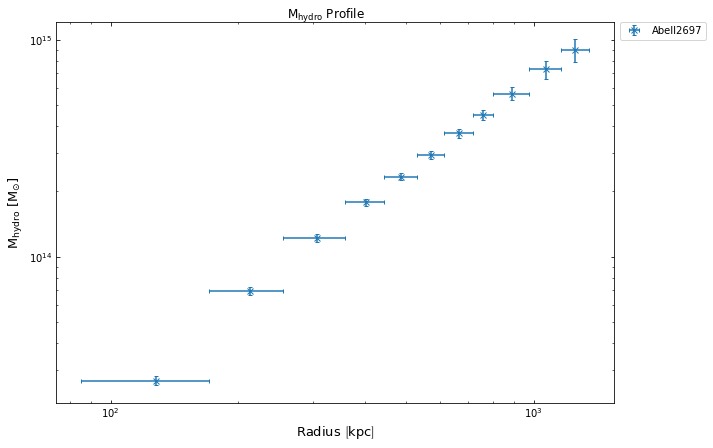

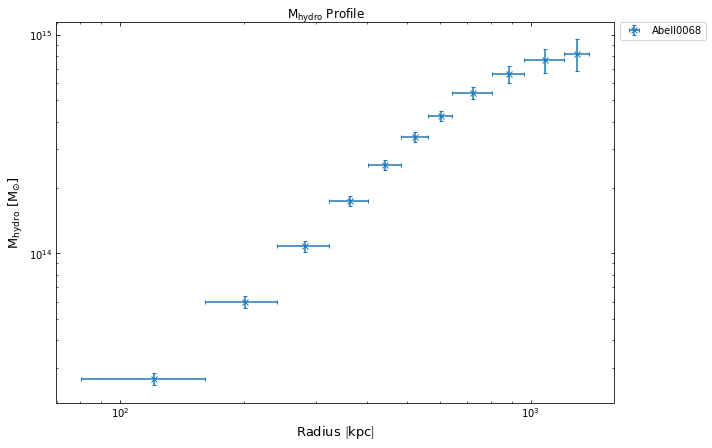

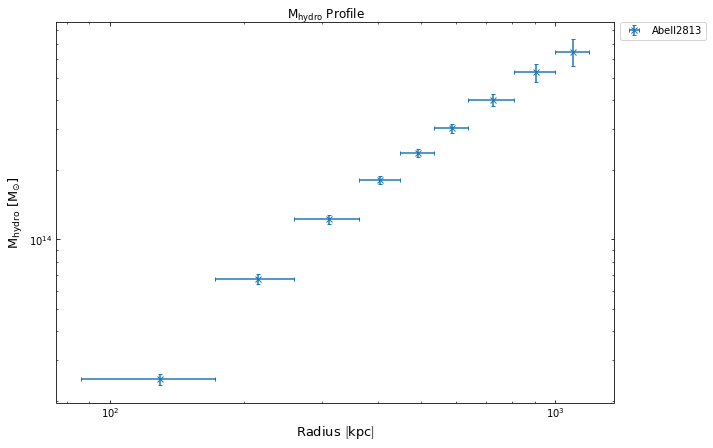

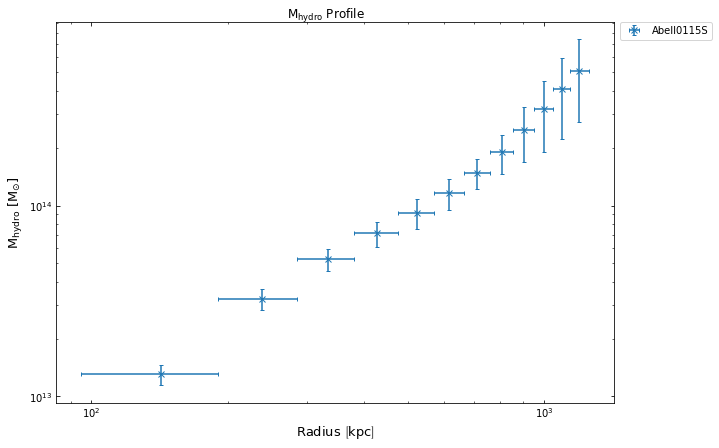

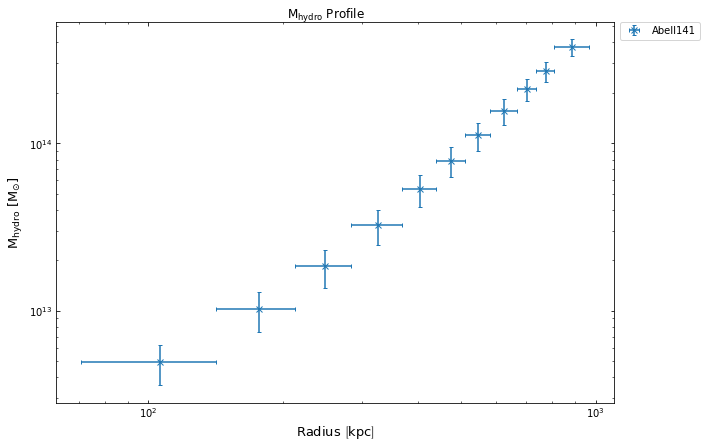

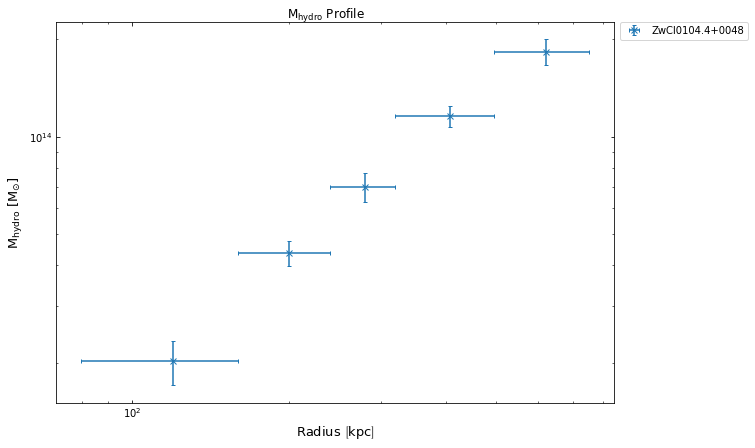

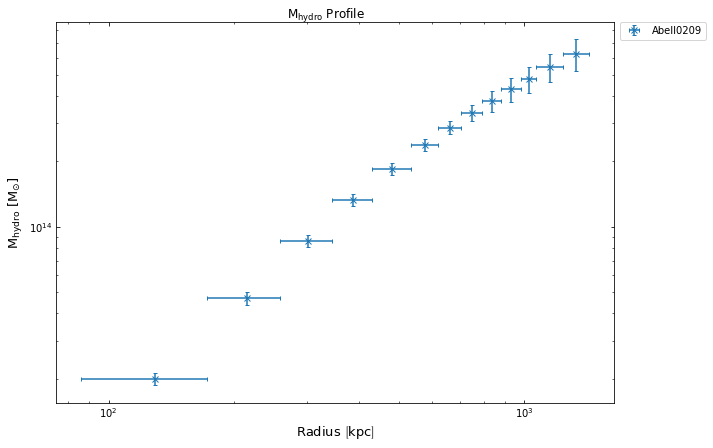

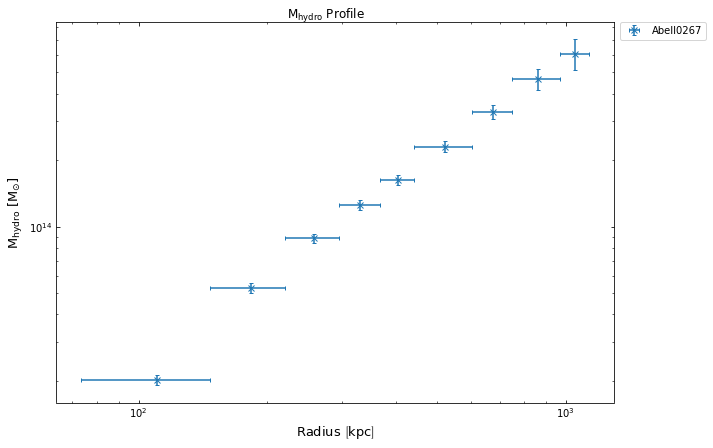

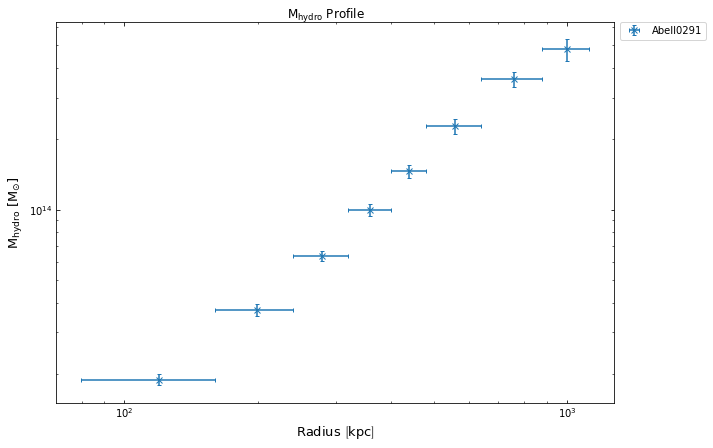

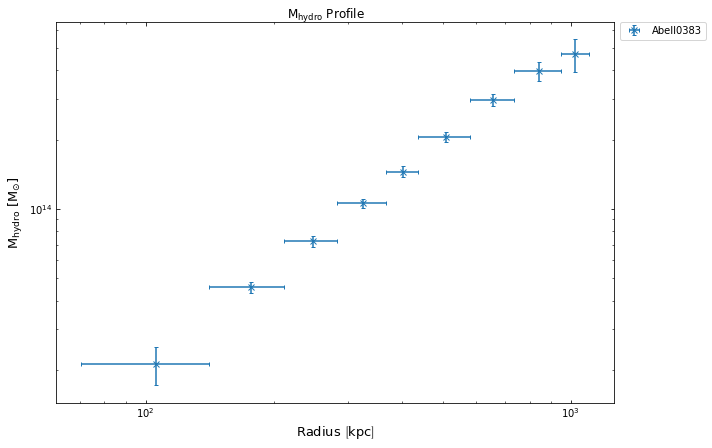

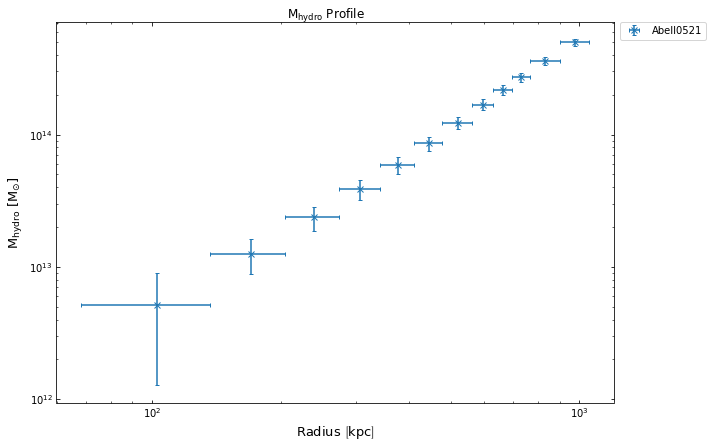

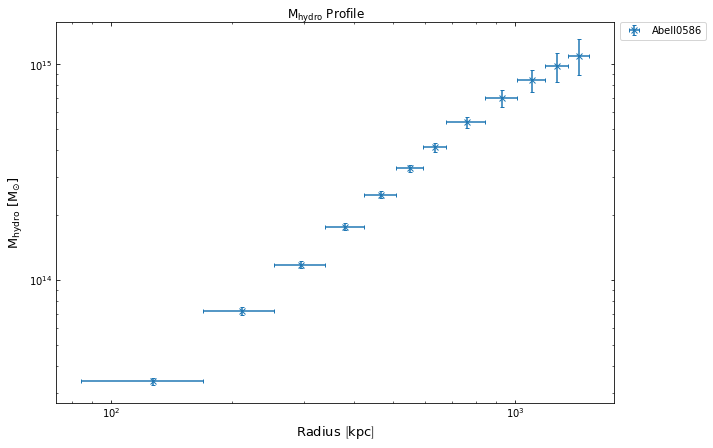

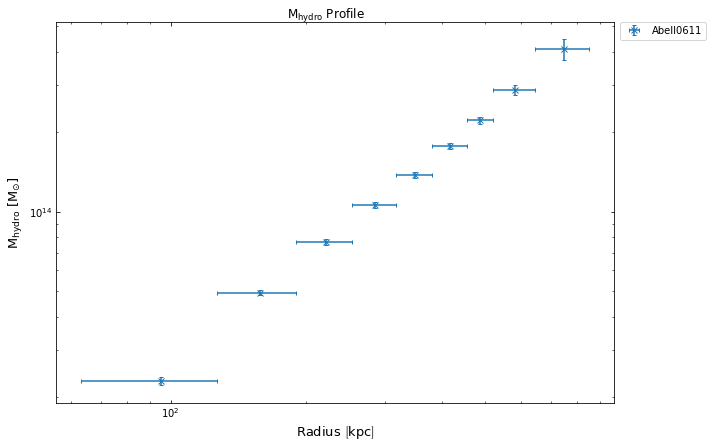

AttributeError: 'NoneType' object has no attribute 'view'

In [58]:
for mp in loc_sb_dblbeta_simpvikh_105_mp:
    mp.view()

[1.34553510e+13 3.42132207e+15]


NameError: name 'loc_lit_ms' is not defined

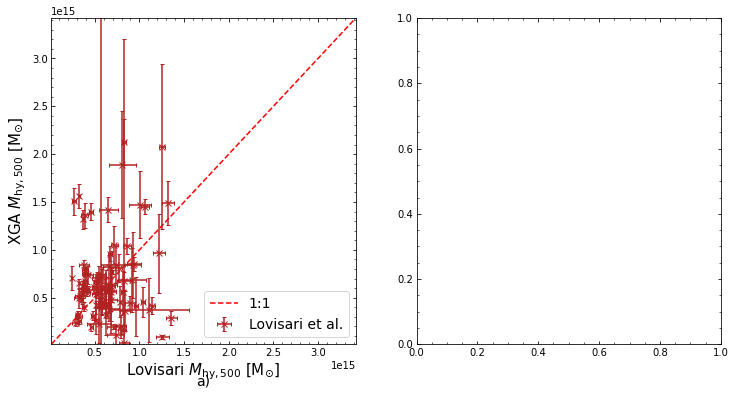

In [21]:
# Setting the y-position and font size of the a and b labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
lov_lims = find_lims(lov_lit_ms, lov_sb_dblbeta_simpvikh_105_m500).value
print(lov_lims)

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_ms[:, 0].value, lov_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=lov_lit_ms[:, 1].value, 
             yerr=lov_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=lov_colour, capsize=2, label=r"Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of mass measurements
loc_lims = find_lims(loc_lit_ms, loc_sb_dblbeta_simpvikh_105_m500).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_ms[:, 0].value, loc_sb_dblbeta_simpvikh_105_m500[:, 0].value, 
             xerr=loc_lit_ms[:, 1].value, 
             yerr=loc_sb_dblbeta_simpvikh_105_m500[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel(r"XGA $M_{\rm{hy,500}}$ [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_sb_dblbeta_svikh_1.05r500_hym500_comp.pdf")
plt.show()